In [3]:
from fastai.vision.all import *
! pip install python-mnist
matplotlib.rc('image', cmap='Greys')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from mnist import MNIST

mndata = MNIST('/workspaces/test/mnist')

images, labels = mndata.load_training()
# or
test_images, test_labels = mndata.load_testing()

#### Load images and group by label

In [5]:
#print(labels[1], mndata.display(images[1]))

df = pd.DataFrame({'label': labels, 'image': images})
test_df = pd.DataFrame({'label': test_labels, 'image': test_images})

label_images_map = {label: df[df.label == label]['image'].tolist() 
                   for label in df.label.unique()}
test_label_images_map = {label: test_df[test_df.label == label]['image'].tolist() 
                   for label in test_df.label.unique()}
tensor_map = {label: torch.stack([tensor(img) for img in imgs]).float()/255
              for label, imgs in label_images_map.items()}
test_tensor_map = {label: torch.stack([tensor(img) for img in imgs]).float()/255
                for label, imgs in test_label_images_map.items()}

del df
del label_images_map
del test_df
del test_label_images_map
import gc
gc.collect()
len(tensor_map[1])



6742

#### calculate average for each label

<Axes: >

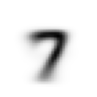

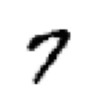

In [6]:
avg_map = {label: tensor_map[label].mean(0) for label in tensor_map.keys()}
show_image(avg_map[7].view(28, 28))
show_image(tensor_map[7][0].view(28, 28))


In [7]:
train_tensors = torch.cat([tensor_map[i] for i in tensor_map.keys()])
test_tensors = torch.cat([test_tensor_map[i] for i in test_tensor_map.keys()])

#train_result = torch.cat([tensor([i]) for i in tensor_map.keys() for j in range(len(tensor_map[i]))])
#test_result = torch.cat([tensor([i]) for i in test_tensor_map.keys() for j in range(len(test_tensor_map[i]))])
#train_result[50000], show_images([t.view(28,28) for t in [train_tensors[50000]]]), train_result.shape

train_dset = [ (img, res) for res in tensor_map.keys() for img in tensor_map[res] ]
test_dset = [ (img, res) for res in test_tensor_map.keys() for img in test_tensor_map[res] ]


(<Axes: >, np.int64(3))

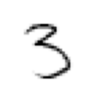

In [31]:
idx = int(random.random()*len(train_dset))
show_image(train_dset[idx][0].view(28, 28)), train_dset[idx][1]

In [9]:
# Step 1: Create neural network
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 128)  # 28x28 = 784 input features
        self.linear2 = nn.Linear(128, 10)   # 10 digits (0-9)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return self.linear2(x)

def calc_loss_per_column_vectorized(preds, targets):
    # Convert probabilities if needed
    probs = F.softmax(preds, dim=1)
    
    # Create one-hot encoding for targets
    one_hot = F.one_hot(targets, num_classes=10).float()
    
    # Calculate loss:
    # For target class: 1 - prob
    # For other classes: prob
    losses = torch.where(one_hot == 1, 
                        1 - probs,  # when target
                        probs) ** 3     # when not target
    
    return losses.sum()

def calc_loss(preds, targets):
    return F.mse_loss(preds, targets)

In [76]:

# Step 2: Create DataLoaders
dl = DataLoader(train_dset, batch_size=512, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=512, shuffle=True)
dls = DataLoaders(dl, test_dl)

# Step 3: Create Learner
model = DigitClassifier()
learn = Learner(dls, model, 
                loss_func=nn.CrossEntropyLoss(),
                metrics=accuracy)

# Step 4: Train
learn.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.563349,0.288624,0.916100,00:01
1,0.237401,0.171802,0.946600,00:01
2,0.138940,0.104398,0.967800,00:01
3,0.094768,0.098556,0.969900,00:01
4,0.067064,0.082902,0.973900,00:01
5,0.044754,0.079183,0.976300,00:01
6,0.028847,0.071384,0.979600,00:01
7,0.018145,0.070107,0.979400,00:01
8,0.011943,0.067792,0.980600,00:01
9,0.010454,0.066890,0.979800,00:01


In [96]:
# Ensure correct shape
idx = int(random.random()*len(test_dset))
x = test_dset[idx][0].float().view(1, -1)  # Reshape to (1, 784)

#im = Image.fromarray((x.view(28, 28)*255).byte().numpy())
#show_image(im)
#print(x.shape)

#im2 = PILImage.create(x.view(28, 28))
# Get prediction
#pred_class, pred_idx, probs = learn.predict(x)

dl = DataLoader([x])
p = learn.get_preds(dl=dl)
F.softmax(p[0]), test_dset[idx][1]


/tmp/ipykernel_62248/889893110.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(p[0]), test_dset[idx][1]


(tensor([1.]), np.int64(6))

In [81]:
test_preds = learn.get_preds(dl=test_dl)
test_preds[0].shape, test_preds[1].shape
preds = F.softmax(test_preds[0], dim=1)
preds = preds.argmax(dim=1)
target = test_preds[1]
df = pd.DataFrame({'pred': preds, 'target': target})
err = df[df.pred != df.target]

target_counts = err['target'].value_counts().sort_index()
print("Distribution of targets:")
print(target_counts, df.shape)

plt.figure(figsize=(10, 5))
target_counts.plot(kind='bar')
plt.title('Number of Samples per Target')
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.show()

KeyboardInterrupt: 

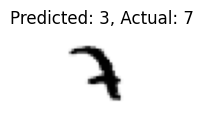

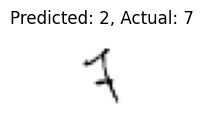

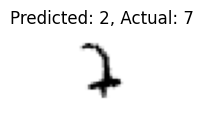

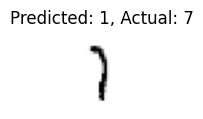

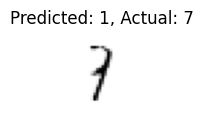

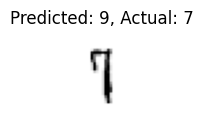

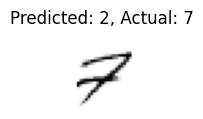

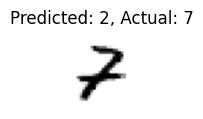

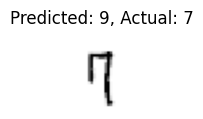

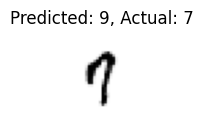

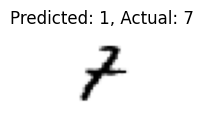

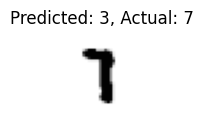

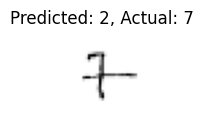

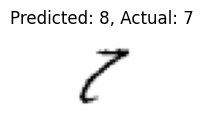

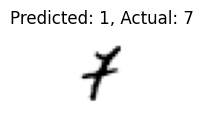

In [12]:

for i in range(15):
    idx = err.index[i]
    show_image(test_dset[idx][0].view(28, 28), title=f'Predicted: {df.pred[idx]}, Actual: {df.target[idx]}')
